In [1]:
import base64
import hashlib
import hmac
import json
from datetime import datetime, timedelta
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import re
import pandas as pd

class DataRepository:

    def __init__(self, private_key, public_key, start_date, end_date):
        self.private_key = private_key
        self.public_key = public_key
        self.start_date = datetime.strptime(start_date, "%Y-%m-%d").date()
        self.end_date = datetime.strptime(end_date, "%Y-%m-%d").date()
        self.url_break = "https://live.luigisbox.com/breakdown?"

    def get_breakdowns(self, td=timedelta(weeks=1)):
        start_date = self.start_date
        actual_date = datetime.now().date()
        
        self._raw_breakdowns = []
        while start_date<actual_date:
            # NOTE: None response handle missing for now
            end_date = start_date+td-timedelta(hours=24)
            query = "&".join([self.url_break+"from="+str(start_date), "to="+str(end_date)])
            temp_break = self._get_response(query)
            temp_break = pd.DataFrame().from_dict(temp_break, orient="index").T
            temp_break["start_date"] = start_date
            temp_break["end_date"] = end_date
            temp_break["public_key"] =  self.public_key
            self._raw_breakdowns.append(temp_break)
            start_date += td

        self.breakdowns = pd.concat(self._raw_breakdowns).reset_index(drop=True) 
        return self.breakdowns

    def _get_breakdown(self, query):
        return None
    
    def _parse_breakdown(self):
        return None
    
    def _get_response(self, query):
        endpoint = re.search(r"/(\w+)\?", query).group(0)[:-1]
        session = self._get_session()
        headers = self._get_headers(endpoint)
        response = session.get(query, headers=headers)
        if response.status_code == 200:
            res = json.loads(response.text)
        else:
            print(f"Error, HTTP status {response.status_code}")
            print(response.text)
            res = None
        return res
    
    def _get_session(self):
        # this should be set from the meth call
        retry_strategy = Retry(
            total=1,
            status_forcelist=[429, 500, 502, 503, 504],
            allowed_methods=["HEAD", "GET", "OPTIONS"])
        session = requests.Session()
        adapter = HTTPAdapter(max_retries=retry_strategy)
        session.mount("https://", adapter)
        session.mount("http://", adapter)
        return session
    
    def _get_headers(self, endpoint):

        def digest(key, method, endpoint, date):
            content_type = "application/json; charset=utf-8"
            data = f"{method}\n{content_type}\n{date}\n{endpoint}"
            signature = hmac.new(key.encode(), data.encode(), hashlib.sha256)
            return base64.b64encode(signature.digest()).decode().strip()
        
        date = datetime.utcnow().strftime('%a, %d %b %Y %H:%M:%S GMT')
        headers = {
            "Content-Type": "application/json; charset=utf-8",
            "Date": date,
            "Authorization": f"faraday {self.public_key}:{digest(self.private_key, 'GET', endpoint, date)}"}                
        return headers

In [2]:
import json
f = open("api.keys")
api_keys = json.load(f)
site_map = {v["public_key"]:k for k, v in api_keys.items()}
f.close()

start_date = "2023-01-30"
end_date = "2023-04-25"

dict_res = []
for k,v in api_keys.items():
    dr = DataRepository(public_key=v["public_key"],
        private_key=v["private_key"],
        start_date=start_date,
        end_date=end_date)
    dict_res.append(dr.get_breakdowns())
data = pd.concat(dict_res)
data["site"] = data.public_key.map(site_map)

/tmp/ipykernel_1655/3942177696.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["ctr"] = 1-data["no_click_searches_percent"]
/tmp/ipykernel_1655/3942177696.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date"] = pd.to_datetime(data["start_date"]).apply(lambda date: date.toordinal())
/tmp/ipykernel_1655/3942177696.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(new_labels);
/tmp/ipykernel_1655/3942177696.py:38: UserWarning: Fixed

<Figure size 640x480 with 0 Axes>

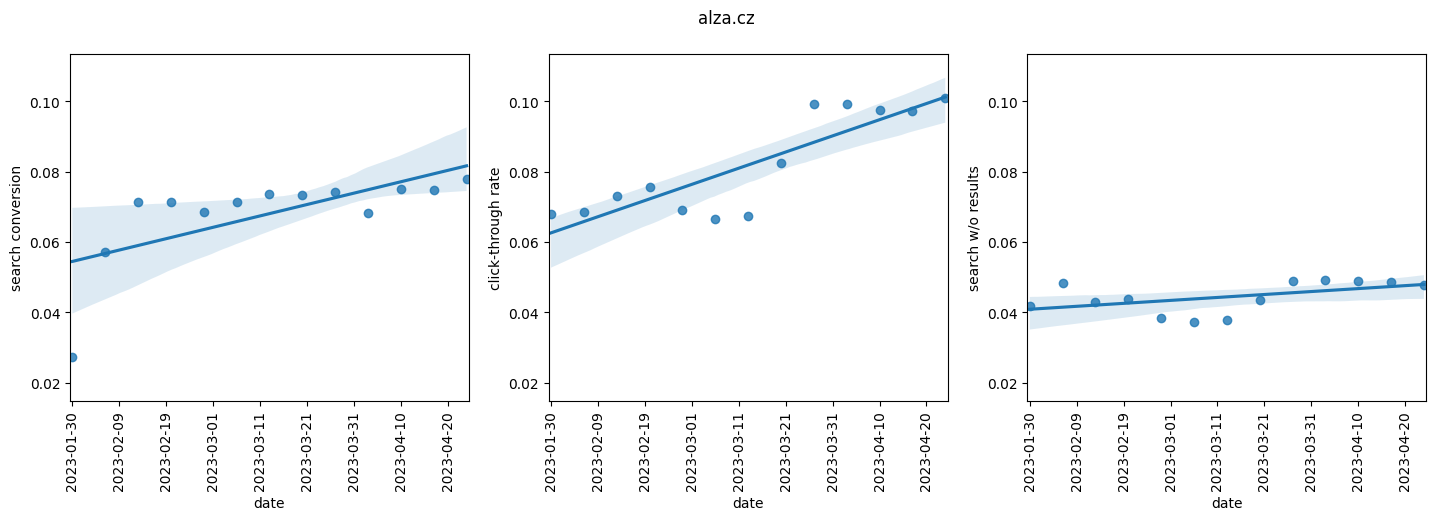

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from datetime import date

def plot_performance(data, site):

    plt.tight_layout()

    data = data[data.site==site]
    data["ctr"] = 1-data["no_click_searches_percent"]
    data["date"] = pd.to_datetime(data["start_date"]).apply(lambda date: date.toordinal())
    y_min = np.min([data["search_converted_percent"].min(), data["ctr"].min(), data["no_results_searches_percent"].min()])-0.0125
    y_max = np.max([data["search_converted_percent"].max(), data["ctr"].max(), data["no_results_searches_percent"].max()])+0.0125

    # conversions
    fig, axs = plt.subplots(1,3,figsize=(17.5,4.5));
    sns.regplot(data=data,
        x="date", y="search_converted_percent", ax=axs[0]);
    axs[0].set_ylabel("search conversion");
    axs[0].set_xlabel("date");
    axs[0].tick_params(axis="x", rotation=90);
    axs[0].set_xlim(data["date"].min() - 0.5, data["date"].max() + 0.5);
    axs[0].set_ylim(y_min,y_max);
    new_labels = [date.fromordinal(int(item)) for item in axs[0].get_xticks()]
    axs[0].set_xticklabels(new_labels);

    # ctr
    sns.regplot(data=data,
        x="date", y="ctr", ax=axs[1]);
    axs[1].set_ylabel("click-through rate");
    axs[1].set_xlabel("date");
    axs[1].tick_params(axis="x", rotation=90);
    axs[1].set_xlim(data["date"].min() - 0.5, data["date"].max() + 0.5);
    axs[1].set_ylim(y_min,y_max);
    #new_labels = [date.fromordinal(int(item)) for item in axs[0].get_xticks()]
    axs[1].set_xticklabels(new_labels);

    # no results
    sns.regplot(data=data,
        x="date", y="no_results_searches_percent", ax=axs[2]);
    axs[2].set_ylabel("search w/o results");
    axs[2].set_xlabel("date");
    axs[2].tick_params(axis="x", rotation=90);
    axs[2].set_xlim(data["date"].min() - 0.5, data["date"].max() + 0.5);
    axs[2].set_ylim(y_min,y_max);
    #new_labels = [date.fromordinal(int(item)) for item in axs[0].get_xticks()]
    axs[2].set_xticklabels(new_labels);
    fig.suptitle(site)
    return None

plot_performance(data, "alza.cz")

/tmp/ipykernel_1655/3942177696.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["ctr"] = 1-data["no_click_searches_percent"]
/tmp/ipykernel_1655/3942177696.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date"] = pd.to_datetime(data["start_date"]).apply(lambda date: date.toordinal())
/tmp/ipykernel_1655/3942177696.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(new_labels);
/tmp/ipykernel_1655/3942177696.py:38: UserWarning: Fixed

<Figure size 640x480 with 0 Axes>

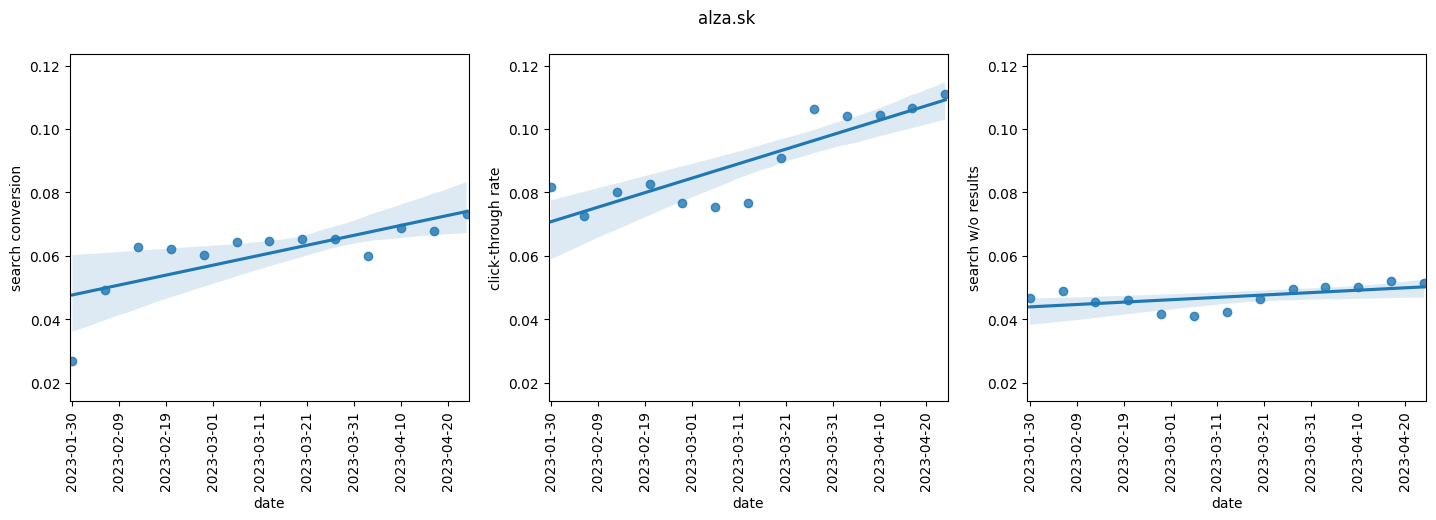

In [7]:
plot_performance(data, "alza.sk")

/tmp/ipykernel_1655/3942177696.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["ctr"] = 1-data["no_click_searches_percent"]
/tmp/ipykernel_1655/3942177696.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date"] = pd.to_datetime(data["start_date"]).apply(lambda date: date.toordinal())
/tmp/ipykernel_1655/3942177696.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(new_labels);
/tmp/ipykernel_1655/3942177696.py:38: UserWarning: Fixed

<Figure size 640x480 with 0 Axes>

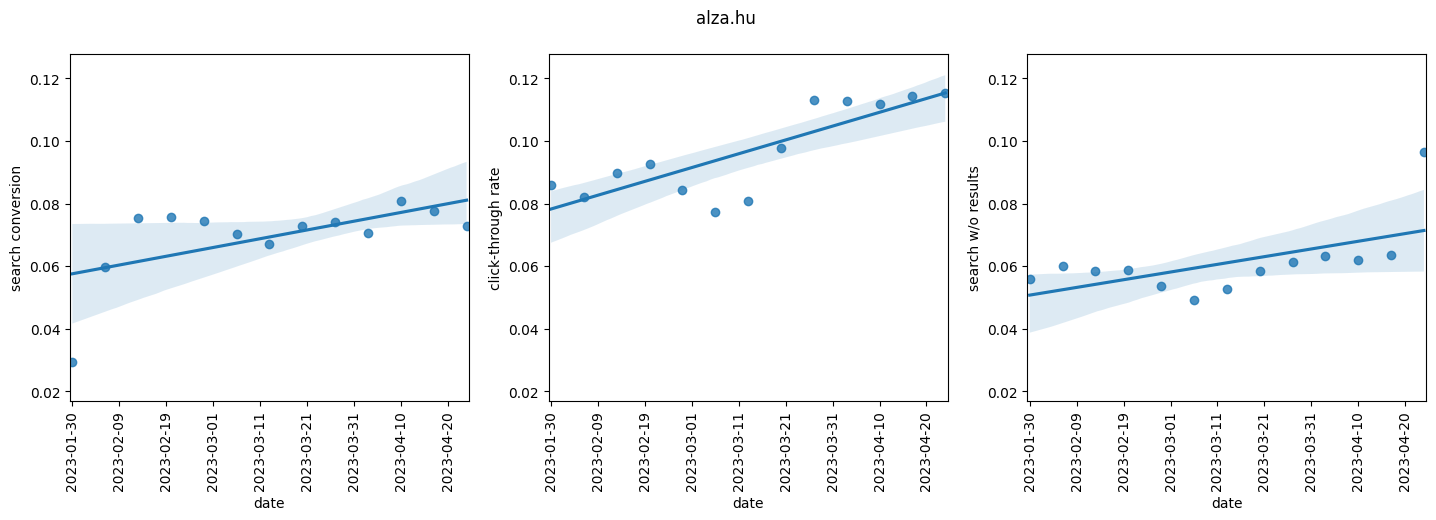

In [8]:
plot_performance(data, "alza.hu")

/tmp/ipykernel_1655/3942177696.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["ctr"] = 1-data["no_click_searches_percent"]
/tmp/ipykernel_1655/3942177696.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date"] = pd.to_datetime(data["start_date"]).apply(lambda date: date.toordinal())
/tmp/ipykernel_1655/3942177696.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(new_labels);
/tmp/ipykernel_1655/3942177696.py:38: UserWarning: Fixed

<Figure size 640x480 with 0 Axes>

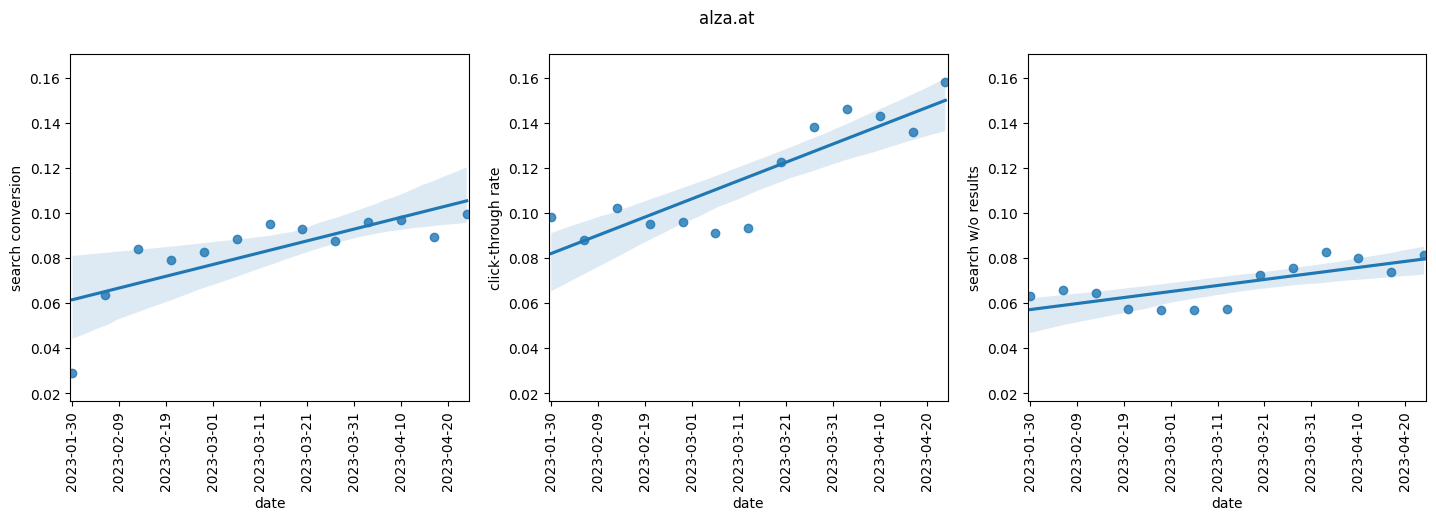

In [9]:
plot_performance(data, "alza.at")

/tmp/ipykernel_1655/3942177696.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["ctr"] = 1-data["no_click_searches_percent"]
/tmp/ipykernel_1655/3942177696.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date"] = pd.to_datetime(data["start_date"]).apply(lambda date: date.toordinal())
/tmp/ipykernel_1655/3942177696.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(new_labels);
/tmp/ipykernel_1655/3942177696.py:38: UserWarning: Fixed

<Figure size 640x480 with 0 Axes>

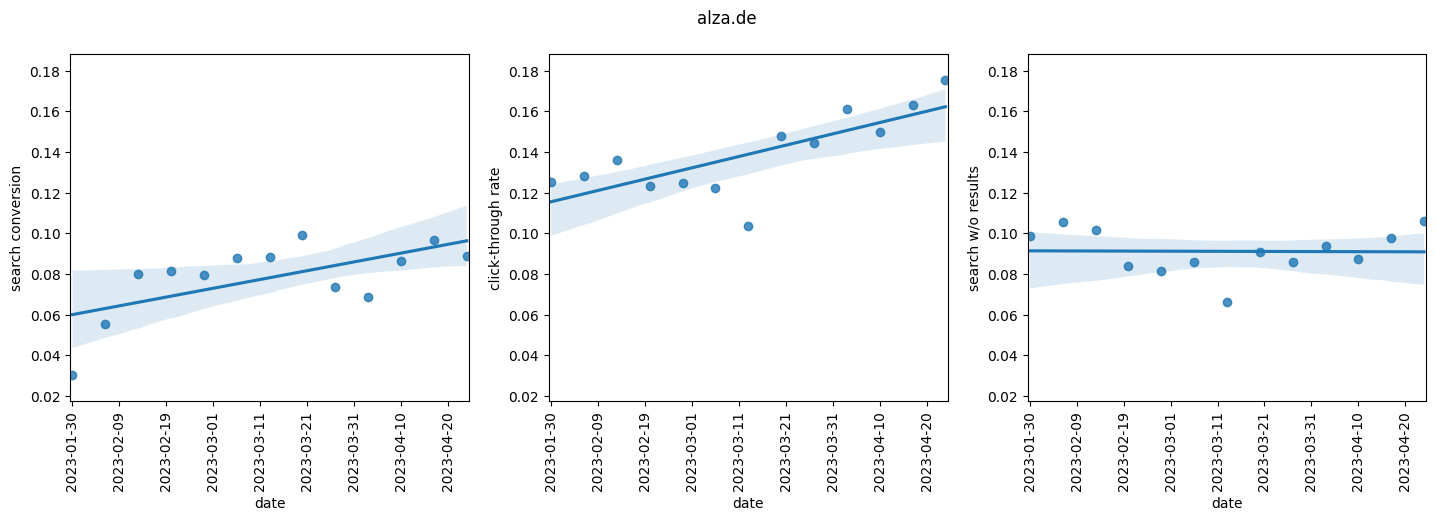

In [10]:
plot_performance(data, "alza.de")